In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# pip install tensorflow

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
# plt.style.use('dark_background')
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')

In [3]:
train_directory = '/content/drive/MyDrive/ML in civil engineering/dataset'
# test_directory = '/home/tsaileshkumar/ML_Project/dataset/test'

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator object
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,  
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
) 

train_generator = train_datagen.flow_from_directory(
train_directory, 
target_size=(224,224), 
color_mode='rgb', 
batch_size=32, 
class_mode='binary', 
subset='training',
shuffle=True,
seed=42
)
validation_generator = val_datagen.flow_from_directory(
train_directory,
target_size=(224,224), 
color_mode='rgb', 
batch_size=32, 
class_mode='binary', 
subset='validation', 
shuffle=False
)

Found 267 images belonging to 2 classes.
Found 65 images belonging to 2 classes.


In [5]:
# from tensorflow.keras.applications import ResNet50


# # Initialize the Pretrained Model
# feature_extractor = ResNet50(weights='imagenet', 
#                              input_shape=(224, 224, 3),
#                              include_top=False)

# # Set this parameter to make sure it's not being trained
# feature_extractor.trainable = False

# # Set the input layer
# input_ = tf.keras.Input(shape=(224, 224, 3))

# # Set the feature extractor layer
# x = feature_extractor(input_, training=False)

# # Set the pooling layer
# x = tf.keras.layers.GlobalAveragePooling2D()(x)

# # Set the final layer with sigmoid activation function
# output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# # Create the new model object
# model = tf.keras.Model(input_, output_)

# # optimizer = tf.keras.optimizers.Adam(learning_rate=10E-6)
# optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.03,
#                                      initial_accumulator_value=0.1,
#                                      epsilon=1e-07)

# # Compile it
# model.compile(optimizer,
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

# # Print The Summary of The Model
# model.summary()

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model


vgg = VGG16(input_shape = (224,224,3), weights = 'imagenet', include_top = False)
for layer in vgg.layers:
 layer.trainable = False
x = Flatten()(vgg.output)
x = Dense(128, activation = 'relu')(x) 
x = Dense(64, activation = 'relu')(x) 
x = Dense(1, activation = 'sigmoid')(x) 
model = Model(inputs = vgg.input, outputs = x)

model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [7]:
from collections import Counter
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}

In [8]:
history_of_model = model.fit(train_generator, epochs=30, validation_data=validation_generator,class_weight=class_weights)

Epoch 1/30
9/9 [==============================] - 32s 2s/step - loss: 0.7275 - accuracy: 0.7004 - val_loss: 0.6267 - val_accuracy: 0.8308
Epoch 2/30
9/9 [==============================] - 5s 523ms/step - loss: 0.3489 - accuracy: 0.9101 - val_loss: 0.7720 - val_accuracy: 0.8000
Epoch 3/30
9/9 [==============================] - 6s 642ms/step - loss: 0.1896 - accuracy: 0.9438 - val_loss: 0.9899 - val_accuracy: 0.6615
Epoch 4/30
9/9 [==============================] - 5s 577ms/step - loss: 0.1975 - accuracy: 0.9363 - val_loss: 0.8129 - val_accuracy: 0.8769
Epoch 5/30
9/9 [==============================] - 5s 512ms/step - loss: 0.1547 - accuracy: 0.9401 - val_loss: 0.9395 - val_accuracy: 0.8462
Epoch 6/30
9/9 [==============================] - 6s 697ms/step - loss: 0.2667 - accuracy: 0.9288 - val_loss: 0.9586 - val_accuracy: 0.6923
Epoch 7/30
9/9 [==============================] - 6s 722ms/step - loss: 0.1765 - accuracy: 0.9401 - val_loss: 1.1273 - val_accuracy: 0.5846
Epoch 8/30
9/9 [======

In [9]:
model.save('VGG_classifier.hdf5') 

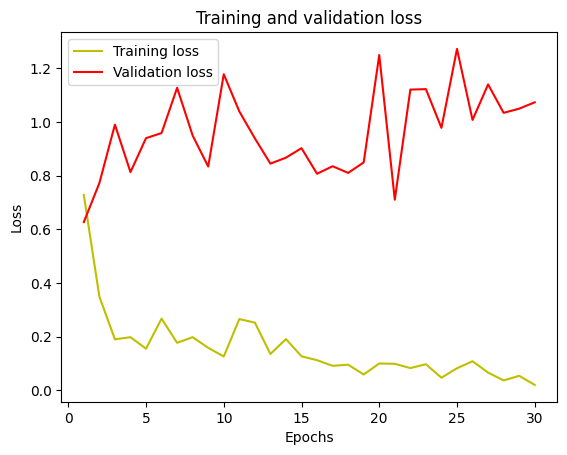

In [10]:
loss = history_of_model.history['loss']
val_loss = history_of_model.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

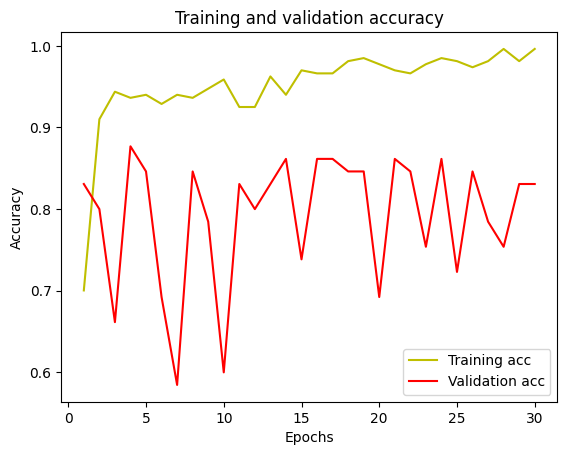

In [11]:
acc = history_of_model.history['accuracy']
val_acc = history_of_model.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

ValueError: ignored

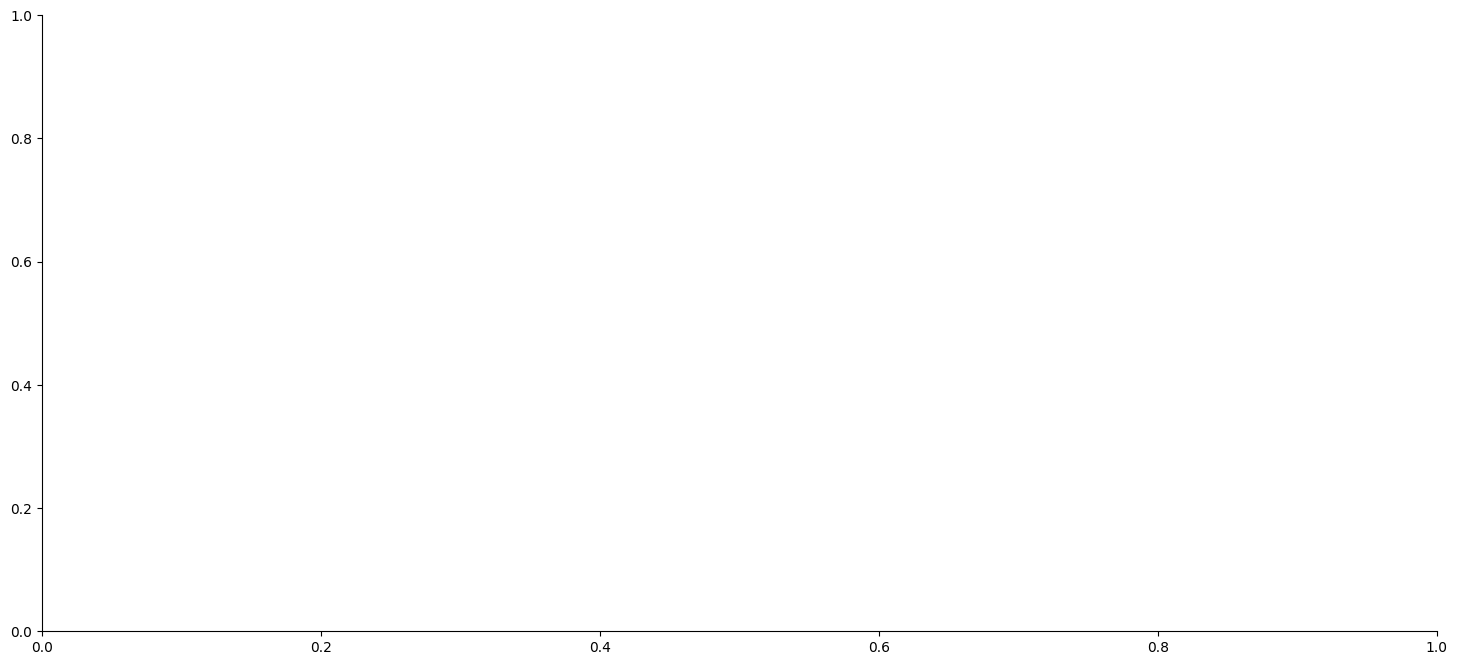

In [12]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False 


# plt.plot(
#     np.arange(1, 21), 
#     history_of_model.history['loss'], 
#     label='Loss', lw=3
# )
plt.plot(
    np.arange(1, 21), 
    history_of_model.history['accuracy'], 
    label='Accuracy', lw=3
)
# plt.plot(
#     np.arange(1, 21), 
#     history_of_model.history['lr'], 
#     label='Learning rate', color='#999', lw=3, linestyle='--'
# )
plt.title('Evaluation metrics', size=30)
plt.xlabel('Epoch', size=14)
plt.legend();

In [ ]:
# learning_rates = 1e-3 * (10 ** (np.arange(50) / 30))
# plt.semilogx(
#     learning_rates, 
#     history_of_model.history['loss'], 
#     lw=3, color='#999'
# )
# plt.title('Learning rate vs. loss', size=20)
# plt.xlabel('Learning rate', size=14)
# plt.ylabel('Loss', size=14);